In [90]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import List

### Data discovery

In [91]:
data = pd.read_csv('spots-monthly.csv')

In [92]:
data

,Date,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,3/8/2024,5.51,5.519176,5.510323,5.485658,5.447398,5.397759,5.338957,5.273209,5.202731,...,4.296355,4.286578,4.276607,4.266443,4.256085,4.245533,4.234786,4.223844,4.212708,4.201376
1,3/7/2024,5.51,5.517688,5.508060,5.483245,5.445374,5.396576,5.338980,5.274715,5.205911,...,4.286568,4.276437,4.266103,4.255566,4.244826,4.233882,4.222734,4.211382,4.199825,4.188063
2,3/6/2024,5.50,5.512081,5.506372,5.485043,5.450262,5.404198,5.349017,5.286890,5.219984,...,4.261798,4.251551,4.241106,4.230464,4.219624,4.208586,4.197350,4.185915,4.174281,4.162448
3,3/5/2024,5.50,5.513579,5.508650,5.487471,5.452298,5.405387,5.348995,5.285377,5.216792,...,4.300351,4.288934,4.277293,4.265428,4.253339,4.241026,4.228489,4.215728,4.202743,4.189533
4,3/4/2024,5.51,5.524352,5.520587,5.500939,5.467642,5.422930,5.369039,5.308201,5.242652,...,4.386380,4.375337,4.364080,4.352609,4.340924,4.329024,4.316910,4.304580,4.292036,4.279276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,10/25/2022,3.56,3.798608,4.001146,4.170144,4.308131,4.417638,4.501194,4.561328,4.600571,...,4.286378,4.269993,4.253317,4.236350,4.219094,4.201550,4.183720,4.165604,4.147203,4.128519
343,10/24/2022,3.57,3.814360,4.020620,4.191606,4.330142,4.439053,4.521164,4.579300,4.616286,...,4.420292,4.404004,4.387428,4.370564,4.353415,4.335980,4.318261,4.300260,4.281977,4.263413
344,10/21/2022,3.55,3.770845,3.958737,4.116195,4.245741,4.349896,4.431181,4.492117,4.535226,...,4.341275,4.324364,4.307160,4.289663,4.271876,4.253798,4.235431,4.216777,4.197837,4.178613
345,10/20/2022,3.58,3.801467,3.991367,4.151999,4.285662,4.394653,4.481273,4.547819,4.596591,...,4.221024,4.204642,4.187974,4.171022,4.153786,4.136268,4.118470,4.100390,4.082032,4.063396


## CIR model

In [93]:
class CIRModel:
    def __init__(self, mu: float, theta: float, sigma: float, r0: float, T: float, dt:float):
        """
        Initialize the CIR model parameters.
        
        :param mu: Speed of mean reversion.
        :param theta: Long-term mean level.
        :param sigma: Volatility.
        :param r0: Initial interest rate.
        :param T: Time horizon for the simulation.
        :param dt: Time step for the simulation.
        """
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.r0 = r0
        self.T = T
        self.dt = dt
        self.num_steps = int(T / dt)
    
    def simulate_paths(self, num_paths: int):
        """
        Simulate multiple paths of the interest rate process.
        
        :param num_paths: Number of paths to simulate.
        :return: Array of simulated paths.
        """
        # Initialize the array to store the paths
        paths = np.zeros((num_paths, self.num_steps + 1))
        paths[:, 0] = self.r0

        
        
        # Generate random numbers for the simulation
        dt_sqrt = np.sqrt(self.dt) #scaling for Brownian motion: increment(W_t) = Z * np.sqrt(dt), WHERE Z ~ N(0,1)
        for t in range(1, self.num_steps + 1):
            Z = np.random.normal(size=num_paths) #dWt
            dw = dt_sqrt * Z
            sqrt_r = np.sqrt(paths[:, t-1])
            paths[:, t] = (paths[:, t-1] + 
                            (self.theta - self.mu * paths[:, t-1]) * self.dt +  #a = theta - mu * r_t, b = sigma * sqrt(r_t)
                           self.sigma * sqrt_r * dw + 
                           0.25 * ((self.sigma ** 2) * sqrt_r) * (dw ** 2 - self.dt)) #b' = 1/2 * sigma, b= sigma * sqrt(sigma)
            
            
            # Ensure non-negativity
            paths[:, t] = np.maximum(paths[:, t], 0)
        
        return paths
    
    def plot_paths(self, num_paths: int =10):
        """
        Plot a few paths of the simulated interest rate process.
        
        :param num_paths: Number of paths to plot.
        """
        paths = self.simulate_paths(num_paths)
        time_points = np.linspace(0, self.T, self.num_steps + 1)
        
        fig = go.Figure()
        
        for i in range(num_paths):
            fig.add_trace(go.Scatter(
                x=time_points, y=paths[i, :],
                mode='lines',
                name=f'Sim path {i + 1}',
                line=dict(width=0.8)
            ))
            
        
        fig.update_layout(
            title='Simulated CIR Model Paths',
            xaxis_title='Time',
            yaxis_title='Interest Rate',
            template='plotly_dark'
        )
        
        fig.show()

    def calibrate(self, market_data: np.array, initial_guess: List[float]):
        """
        Calibrate the CIR model parameters to market data.
        
        :param market_data: Market data to calibrate to (e.g., volatility matrix).
        :param initial_guess: Initial guess for the model parameters [mu, theta, sigma].
        :return: Calibrated parameters.
        """
        def objective(params: List[float]):
            self.mu, self.theta, self.sigma = params
            simulated_data = self.simulate_paths(len(market_data))
            simulated_vol = np.std(simulated_data, axis=0)
            market_vol = np.std(market_data, axis=0)
            error = np.sum((simulated_vol - market_vol) ** 2)
            return error

        result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=[(0, None), (0, None), (0, None)])
        self.mu, self.theta, self.sigma = result.x
        return result.x


        # Assuming option expires at t_end
    # Spot price is y_start, so we don't use it as a parameter here
    def price_option(self, is_call: bool, K: float, T: float, num_paths: int):
        """
        Price a European option using Monte Carlo simulation.
        
        :param option_type: 'call' or 'put'.
        :param K: Strike price of the option.
        :param T: Time to maturity.
        :param num_paths: Number of simulated paths.
        :return: Estimated option price.
        """
        paths = self.simulate_paths(num_paths)
        final_rates = paths[:, -1]
        
        if is_call == True:
            payoffs = np.maximum(final_rates - K, 0)
        else:
            payoffs = np.maximum(K - final_rates, 0)
        
        # Discount payoffs back to present value
        discount_factor = np.exp(-self.r0 * T)
        option_price = discount_factor * np.mean(payoffs)
        return option_price


if __name__ == "__main__":
    # Initialize 
    cir = CIRModel(mu=0.5, theta=0.04, sigma=0.1, r0=0.03, T=1.0, dt=0.01)
    
    # Market data for calibration
    market_data = data.iloc[:,1:102].to_numpy()
    
    # Calibrate 
    initial_guess = [0.4, 0.03, 0.08]
    calibrated_params = cir.calibrate(market_data, initial_guess)
    print(f"Calibrated parameters: \
    \n mu: {round(calibrated_params[0], 6)}, \
    \n theta: {round(calibrated_params[1], 6)}, \
    \n sigma: {round(calibrated_params[2], 6)}")
    
    # Plot 
    cir.plot_paths(100)

Calibrated parameters:     
 mu: 0.400001,     
 theta: 0.030001,     
 sigma: 0.08


In [97]:
cir.price_option(is_call=True, K=0.07, T=1, num_paths=1000)

0.0002440424489309644

## Vasicek model

Calibrated parameters:     
 mu: 0.400002,     
 theta: 0.030001,     
 sigma: 0.080001


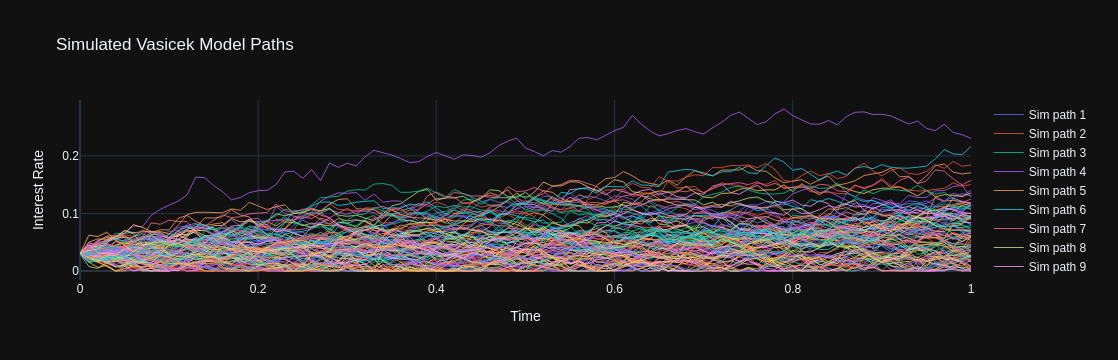

In [98]:
import numpy as np
from scipy.optimize import minimize
import plotly.graph_objects as go
from typing import List
# a(x) = theta - mu * paths (czyli r_t czyli x)
#b(x) = sigma * paths

class VasicekModel:
    def __init__(self, mu: float, theta: float, sigma: float, r0: float, T: float, dt: float):
        """
        Initialize the Vasicek model parameters.
        
        :param mu: Speed of mean reversion.
        :param theta: Long-term mean level.
        :param sigma: Volatility.
        :param r0: Initial interest rate.
        :param T: Time horizon for the simulation.
        :param dt: Time step for the simulation.
        :param num_paths: Number of paths to simulate.
        """
        self.mu = mu #alpha
        self.theta = theta
        self.sigma = sigma
        self.r0 = r0
        self.T = T
        self.dt = dt
        self.num_steps = int(T / dt)
    
    def simulate_paths(self, num_paths: int):
        """
        Simulate multiple paths of the interest rate process.
        
        :return: Array of simulated paths.
        """
        # Initialize the array to store the paths
        paths = np.zeros((num_paths, self.num_steps + 1))
        paths[:, 0] = self.r0
        
        # Generate random numbers for the simulation
        dt_sqrt = np.sqrt(self.dt) #scaling for Brownian motion: increment(W_t) = Z * np.sqrt(dt), WHERE Z ~ N(0,1)
        for t in range(1, self.num_steps + 1):
            Z = np.random.normal(size=num_paths) #dWt
            dw = dt_sqrt * Z
            sqrt_r = np.sqrt(paths[:, t-1])
            paths[:, t] = (paths[:, t-1] + 
                            (self.theta - self.mu * paths[:, t-1]) * self.dt + 
                           self.sigma * dw + 
                           0.5 * self.sigma * (dw ** 2 - self.dt)) #b' = 1, b = sigma
            # Ensure non-negativity
            paths[:, t] = np.maximum(paths[:, t], 0)
            
        return paths

    
    def plot_paths(self, num_paths: float =10):
        """
        Plot a few paths of the simulated interest rate process.
        """
        paths = self.simulate_paths(num_paths)
        time_points = np.linspace(0, self.T, self.num_steps + 1)
        
        fig = go.Figure()
        
        for i in range(num_paths):
            fig.add_trace(go.Scatter(
                x=time_points, y=paths[i, :],
                mode='lines',
                name=f'Sim path {i + 1}',
                line=dict(width=0.8)
            ))
            
        
        fig.update_layout(
            title='Simulated Vasicek Model Paths',
            xaxis_title='Time',
            yaxis_title='Interest Rate',
            template='plotly_dark'
        )
        
        fig.show()

    def calibrate(self, market_data: np.array, initial_guess: List[float]):
        """
        Calibrate the Vasicek model parameters to market data.
        
        :param market_data: Market data to calibrate to (e.g., volatility matrix).
        :param initial_guess: Initial guess for the model parameters [mu, theta, sigma].
        :return: Calibrated parameters.
        """
        def objective(params: List[float]):
            self.mu, self.theta, self.sigma = params
            simulated_data = self.simulate_paths(len(market_data))
            simulated_vol = np.std(simulated_data, axis=0)
            market_vol = np.std(market_data, axis=0)
            error = np.sum((simulated_vol - market_vol) ** 2)
            return error

        result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=[(0, None), (0, None), (0, None)])
        self.mu, self.theta, self.sigma = result.x
        return result.x


    def price_option(self, is_call: bool, K: float, T: float, num_paths: int):
        """
        Price a European option using Monte Carlo simulation.
        
        :param option_type: 'call' or 'put'.
        :param K: Strike price of the option.
        :param T: Time to maturity.
        :param num_paths: Number of simulated paths.
        :return: Estimated option price.
        """
        paths = self.simulate_paths(num_paths)
        final_rates = paths[:, -1]
        
        if is_call == True:
            payoffs = np.maximum(final_rates - K, 0)
        else:
            payoffs = np.maximum(K - final_rates, 0)
        
        # Discount payoffs back to present value
        discount_factor = np.exp(-self.r0 * T)
        option_price = discount_factor * np.mean(payoffs)
        return option_price

if __name__ == "__main__":
    # Initialize the Vasicek model with some parameters
    vasicek = VasicekModel(mu=0.5, theta=0.04, sigma=0.1, r0=0.03, T=1.0, dt=0.01)
    
    # Calibrate the model to the synthetic market data
    initial_guess = [0.4, 0.03, 0.08]
    calibrated_params = vasicek.calibrate(market_data, initial_guess)
    print(f"Calibrated parameters: \
    \n mu: {round(calibrated_params[0],6)}, \
    \n theta: {round(calibrated_params[1], 6)}, \
    \n sigma: {round(calibrated_params[2],6)}")
    
    # Plot the simulated paths with calibrated parameters
    vasicek.plot_paths(100)


In [105]:
vasicek.price_option(is_call=False, K=0.1, T=1, num_paths=1000)

0.04134937165199136

## RB model

Calibrated parameters:     
 mu: 0.399999,     
 theta: 0.03,     
 sigma: 0.079998


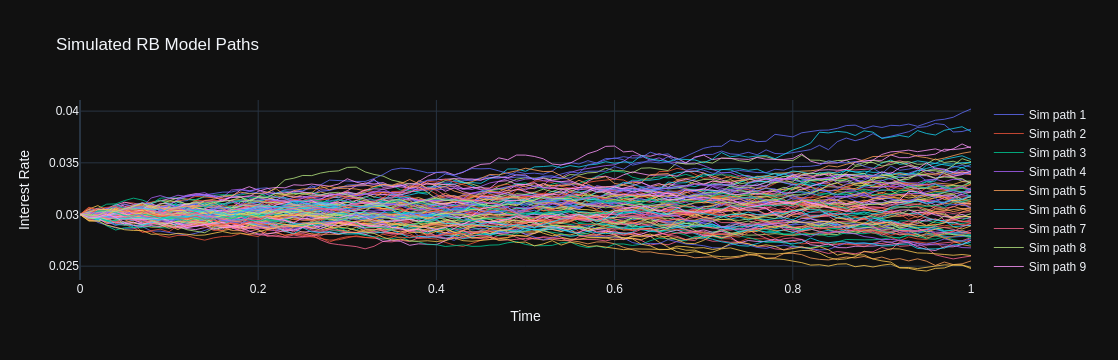

In [101]:
class RBModel:
    def __init__(self, mu: float, theta:float, sigma: float, r0: float, T: float, dt: float):
        """
        Initialize the RB model parameters.
        
        :param mu: Speed of mean reversion.
        :param theta: Long-term mean level.
        :param sigma: Volatility.
        :param r0: Initial interest rate.
        :param T: Time horizon for the simulation.
        :param dt: Time step for the simulation.
        """
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.r0 = r0
        self.T = T
        self.dt = dt
        self.num_steps = int(T / dt)
    
    def simulate_paths(self, num_paths: int):
        """
        Simulate multiple paths of the interest rate process.
        
        :param num_paths: Number of paths to simulate.
        :return: Array of simulated paths.
        """
        # Initialize the array to store the paths
        paths = np.zeros((num_paths, self.num_steps + 1))
        paths[:, 0] = self.r0

        # Generate random numbers for the simulation
        dt_sqrt = np.sqrt(self.dt) #scaling for Brownian motion: increment(W_t) = Z * np.sqrt(dt), WHERE Z ~ N(0,1)
        for t in range(1, self.num_steps + 1):
            Z = np.random.normal(size=num_paths) #dWt
            dw = dt_sqrt * Z
            sqrt_r = np.sqrt(paths[:, t-1])
            paths[:, t] = (paths[:, t-1] + 
                            (self.theta * paths[:, t-1]) * self.dt +  # a = theta * r_t, b = sigma * r_t
                           self.sigma * paths[:, t-1] * dw + 
                           0.5 * (self.sigma ** 2) * paths[:, t-1] * (dw ** 2 - self.dt)) #b' = sigma, b = sigma * r_t
            
            
            # Ensure non-negativity
            paths[:, t] = np.maximum(paths[:, t], 0)
        
        return paths
    
    def plot_paths(self, num_paths: int =10):
        """
        Plot a few paths of the simulated interest rate process.
        
        :param num_paths: Number of paths to plot.
        """
        paths = self.simulate_paths(num_paths)
        time_points = np.linspace(0, self.T, self.num_steps + 1)
        
        fig = go.Figure()
        
        for i in range(num_paths):
            fig.add_trace(go.Scatter(
                x=time_points, y=paths[i, :],
                mode='lines',
                name=f'Sim path {i + 1}',
                line=dict(width=0.8)
            ))
            
        
        fig.update_layout(
            title='Simulated RB Model Paths',
            xaxis_title='Time',
            yaxis_title='Interest Rate',
            template='plotly_dark'
        )
        
        fig.show()

    def calibrate(self, market_data: np.array, initial_guess: List[float]):
        """
        Calibrate the RB model parameters to market data.
        
        :param market_data: Market data to calibrate to (e.g., volatility matrix).
        :param initial_guess: Initial guess for the model parameters [mu, theta, sigma].
        :return: Calibrated parameters.
        """
        def objective(params: List[float]):
            self.mu, self.theta, self.sigma = params
            simulated_data = self.simulate_paths(len(market_data))
            simulated_vol = np.std(simulated_data, axis=0)
            market_vol = np.std(market_data, axis=0)
            error = np.sum((simulated_vol - market_vol) ** 2)
            return error

        result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=[(0, None), (0, None), (0, None)])
        self.mu, self.theta, self.sigma = result.x
        return result.x

    def price_option(self, is_call: bool, K: float, T: float, num_paths: int):
        """
        Price a European option using Monte Carlo simulation.
        
        :param option_type: 'call' or 'put'.
        :param K: Strike price of the option.
        :param T: Time to maturity.
        :param num_paths: Number of simulated paths.
        :return: Estimated option price.
        """
        paths = self.simulate_paths(num_paths)
        final_rates = paths[:, -1]
        
        if is_call == True:
            payoffs = np.maximum(final_rates - K, 0)
        else:
            payoffs = np.maximum(K - final_rates, 0)
        
        # Discount payoffs back to present value
        discount_factor = np.exp(-self.r0 * T)
        option_price = discount_factor * np.mean(payoffs)
        return option_price


# Example usage
if __name__ == "__main__":
    # Initialize the RB model with some parameters
    rb = RBModel(mu=0.5, theta=0.04, sigma=0.1, r0=0.03, T=1.0, dt=0.01)
    
    # Generate some synthetic market data for calibration (for illustration purposes)
    market_data = data.iloc[:,1:102].to_numpy()
    
    # Calibrate the model to the synthetic market data
    initial_guess = [0.4, 0.03, 0.08]
    calibrated_params = rb.calibrate(market_data, initial_guess)
    print(f"Calibrated parameters: \
    \n mu: {round(calibrated_params[0], 6)}, \
    \n theta: {round(calibrated_params[1], 6)}, \
    \n sigma: {round(calibrated_params[2], 6)}")
    
    # Plot the simulated paths with calibrated parameters
    rb.plot_paths(100)

In [104]:
rb.price_option(is_call=True, K=0.03, T=1, num_paths=1000)

0.0015539999381873656